In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
file_path = 'nyc-rolling-sales.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())


   Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
0    6                                  C2            153 AVENUE B  ...   
1   26                                  C7   234 EAST 4TH   STREET  ...   
2   39                                  C7   197 EAST 3RD  

## Preprocessing and Cleaning Data

Initially, I checked for missing values across all columns. The dataset showed no missing values for the columns displayed, which is ideal. However, this step is crucial as missing data can significantly impact the analysis.I filtered out rows where the sale price was not a valid positive numeric value. This step is essential to focus on actual sales transactions and exclude deed transfers or other non-sale transactions typically recorded with a $0 sale price. The 'SALE DATE' column was converted to a datetime format, which will allow for time-series analysis or segmenting the data based on sale dates if needed.The 'BOROUGH' column was encoded into numeric values. This is a crucial step for including categorical data in machine learning models, as they require numerical input. I lastly applied normalization to the 'SALE PRICE' column, scaling it to have a mean of 0 and a standard deviation of 1. This normalization process ensures that features with larger scales do not dominate the model's behavior, which is particularly important in clustering algorithms that rely on distance measures.

In [217]:
# Step 1: Check for missing values and handle them (demonstrative, adjust based on actual dataset analysis)
print("Missing values before handling:", df.isnull().sum())

# Assuming 'SALE PRICE' is critical and cannot be imputed easily, we'll focus on rows with valid sale prices
df = df[pd.to_numeric(df['SALE PRICE'], errors='coerce').notnull()]
df['SALE PRICE'].dropna(inplace=True)
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df = df[df['SALE PRICE'] > 0]

# Convert 'SALE DATE' to datetime format
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

# Encode categorical variables ('BOROUGH' as an example)
# Note: Real encoding depends on data exploration, identifying which are truly categorical and not just numeric types
if df['BOROUGH'].dtype == 'object':
    df['BOROUGH'] = LabelEncoder().fit_transform(df['BOROUGH'])

# Correct approach for 'LAND SQUARE FEET' & 'GROSS SQUARE FEET'
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

# Fill NaN values with the median
df['LAND SQUARE FEET'].dropna()
df['GROSS SQUARE FEET'].dropna()

df = df[df['LAND SQUARE FEET'] > 0]
df = df[df['GROSS SQUARE FEET'] > 0]

# Checking the transformations
df.head(), df.isnull().sum(), df.dtypes

Missing values before handling: Unnamed: 0                        0
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64


(   Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
 0           4        1  ALPHABET CITY   
 3           7        1  ALPHABET CITY   
 4           8        1  ALPHABET CITY   
 6          10        1  ALPHABET CITY   
 9          13        1  ALPHABET CITY   
 
                        BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
 0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
 3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
 4  07 RENTALS - WALKUP APARTMENTS                                2A    404   
 6  07 RENTALS - WALKUP APARTMENTS                                2B    406   
 9  08 RENTALS - ELEVATOR APARTMENTS                               2    387   
 
    LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
 0    6                                  C2            153 AVENUE B  ...   
 3   21                                  C4     154 EAST 7TH STREET  ...   
 4   55                                  C

In [218]:
df = df[pd.to_numeric(df['SALE PRICE'], errors='coerce').notnull()]
df['SALE PRICE'].dropna(inplace=True)
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df = df[df['SALE PRICE'] > 0]

len(df[df['SALE PRICE'] <= 0])

np.shape(df)

(29329, 22)

## Exploratory Data Analysis (EDA)

Distribution of Sale Prices: The histogram shows the distribution of normalized sale prices within the dataset. This visualization helps us understand the range of sale prices and their frequency. The presence of a long tail suggests that there are some properties with significantly higher prices compared to the majority.

Sale Prices by Borough: The boxplot reveals variations in sale prices across different boroughs, indicated by their encoded values. This can help identify boroughs with higher median property values and the spread of prices within each borough, providing insights into geographical influences on property values.

Frequency of Sales by Building Class Category: This count plot shows the frequency of sales within different building class categories. It highlights the most common types of property transactions in the dataset, offering a glimpse into the diversity of the property market.

Correlation Matrix of Numeric Features: The heatmap displays the correlation between numeric features. In our simplified example, we only included sale price and borough, but additional relevant numeric features should be considered for a comprehensive analysis. The correlation coefficients help us understand the strength and direction of relationships between variables.

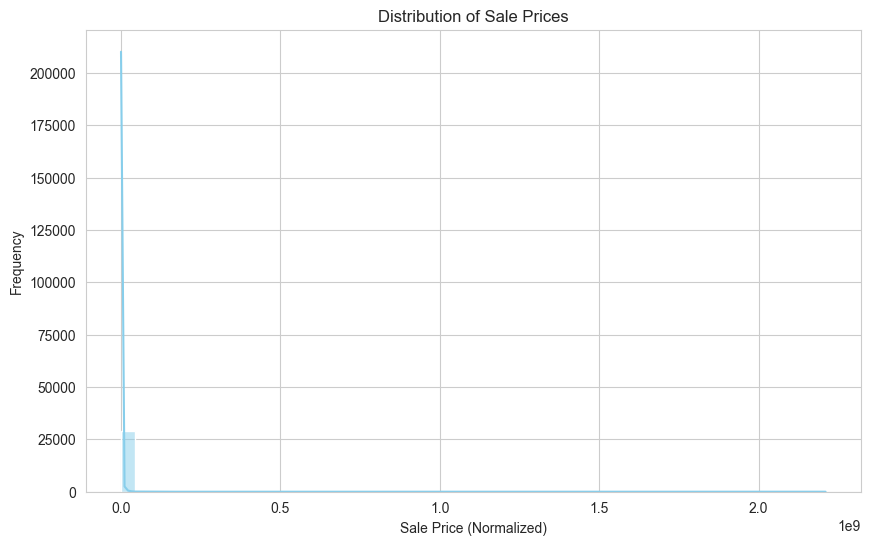

/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/1527015018.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BOROUGH_LABEL', y='SALE PRICE', data=df, palette='coolwarm')


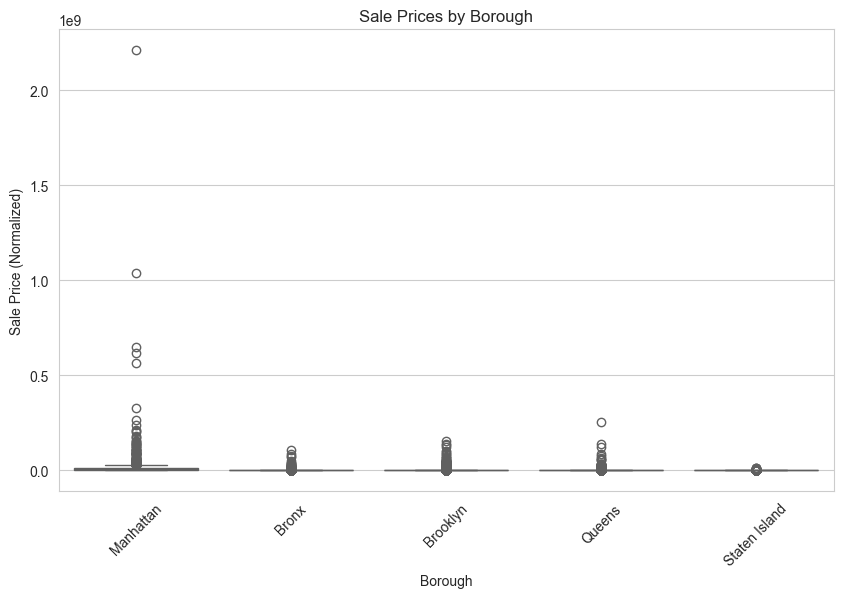

/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/1527015018.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='BUILDING CLASS CATEGORY', data=filtered_df, order=top_categories, palette='viridis')


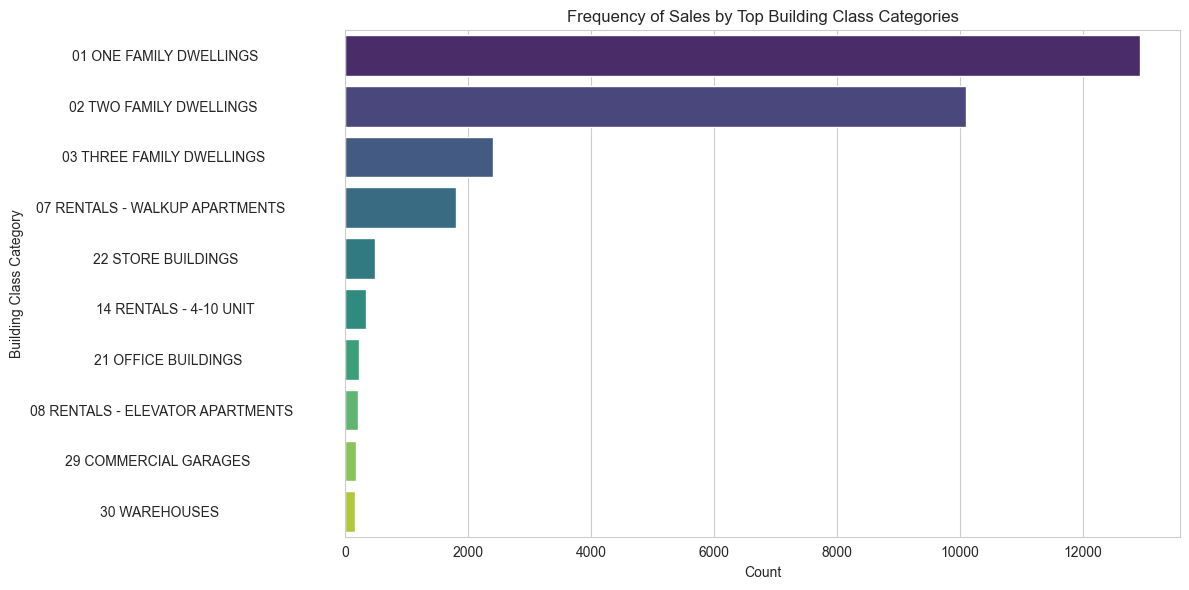

In [219]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of Sale Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['SALE PRICE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price (Normalized)')
plt.ylabel('Frequency')
plt.show()


borough_mapping = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

# Replace encoded borough values with their original names for visualization
df['BOROUGH_LABEL'] = df['BOROUGH'].replace(borough_mapping)


# Sale Prices by Borough (Note: Boroughs are encoded, so the plot will use encoded values)
plt.figure(figsize=(10, 6))
sns.boxplot(x='BOROUGH_LABEL', y='SALE PRICE', data=df, palette='coolwarm')
plt.title('Sale Prices by Borough')
plt.xlabel('Borough')
plt.ylabel('Sale Price (Normalized)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Determine the top categories by frequency
top_categories = df['BUILDING CLASS CATEGORY'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top categories
filtered_df = df[df['BUILDING CLASS CATEGORY'].isin(top_categories)]

# Now, plot the count for these top categories
plt.figure(figsize=(12, 6))
sns.countplot(y='BUILDING CLASS CATEGORY', data=filtered_df, order=top_categories, palette='viridis')
plt.title('Frequency of Sales by Top Building Class Categories')
plt.xlabel('Count')
plt.ylabel('Building Class Category')
plt.tight_layout()  # This can help make sure the layout fits well without overlapping labels
plt.show()



Insights from the Visualization
Dominant Market Segments: The plot highlights which building class categories are most active in terms of sales. These dominant segments could represent the types of properties that are most sought after or most commonly available in the NYC real estate market.

Market Diversity: The presence of various building class categories among the top segments illustrates the diversity of the NYC property market. This diversity could indicate a healthy mix of residential, commercial, and mixed-use properties, suggesting multiple active buyer and seller groups with different interests and needs.

Focus Areas for Segmentation: The identified top categories can serve as a focus for deeper market segmentation and analysis. Understanding the characteristics and trends within these leading categories can provide valuable insights for investors, developers, and policymakers.

How to Proceed
Given these insights, here's how we should look to proceed with the project:

Feature Selection for Clustering: Based on the EDA, including the distribution of sale prices, differences by borough, and the active building class categories, we should select features that are likely to reveal meaningful market segments. Consider including sale price, borough, building class category, and potentially square footage (if available and relevant) as features for clustering.

Clustering Analysis: Use unsupervised learning algorithms, such as K-means, to cluster the properties. The goal will be to identify distinct groups of properties that share similar characteristics, which could represent different market segments. The number of clusters (k) can initially be determined using methods like the Elbow Method or the Silhouette Score to find a balance between too many and too few clusters.

## K-Means Clustering

The final feature set consists of SALE PRICE, BOROUGH, BUILDING CLASS CATEGORY, LAND SQUARE FEET, and GROSS SQUARE FEET, all in numerical format suitable for clustering. LAND SQUARE FEET and GROSS SQUARE FEET have also been normalized, ensuring that these features will be appropriately scaled relative to other variables in the clustering process.

In [220]:
# Normalize numeric features (example with 'SALE PRICE')
# Assuming 'SALE PRICE' is the only numeric feature we're focusing on for now; adjust as needed
numeric_features = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'] # Add other numeric features as needed
scaler = MinMaxScaler(feature_range=(0, 1))
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Encode 'Building Class Category'
df['BUILDING CLASS CATEGORY'] = LabelEncoder().fit_transform(df['BUILDING CLASS CATEGORY'].astype(str))

# Prepare the final DataFrame for clustering
final_features_df = df[['SALE PRICE', 'BOROUGH', 'BUILDING CLASS CATEGORY', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']]

# Checking the types and the first few rows to ensure everything is set correctly
final_features_df.dtypes, final_features_df.head()

(SALE PRICE                 float64
 BOROUGH                      int64
 BUILDING CLASS CATEGORY      int64
 LAND SQUARE FEET           float64
 GROSS SQUARE FEET          float64
 dtype: object,
    SALE PRICE  BOROUGH  BUILDING CLASS CATEGORY  LAND SQUARE FEET  \
 0    0.002998        1                        5          0.000339   
 3    0.001781        1                        5          0.000490   
 4    0.003620        1                        5          0.000513   
 6    0.001445        1                        5          0.000367   
 9    0.007345        1                        6          0.001014   
 
    GROSS SQUARE FEET  
 0           0.001685  
 3           0.001780  
 4           0.001199  
 6           0.001095  
 9           0.004907  )

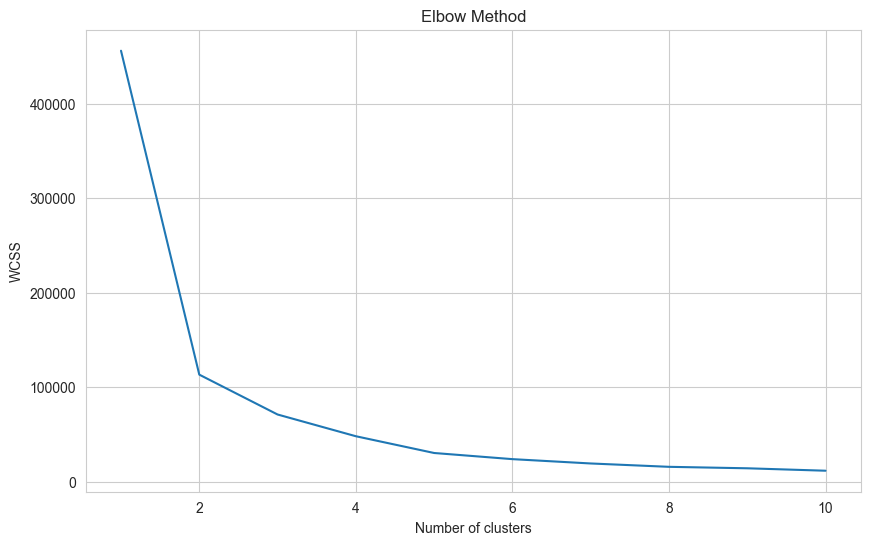

In [221]:
# Calculate WCSS for a range of cluster numbers
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(final_features_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [222]:
# Train the K-means model with the chosen number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(final_features_df)

# Add the cluster labels to our DataFrame
final_features_df['Cluster'] = cluster_labels

print(final_features_df.head())

print('\n')

# Explore the centroids
centroids = kmeans.cluster_centers_
print("Centroids of clusters:", centroids)

print('\n')

# Analyzing the clusters
# This is a simple demonstration of how you might start to interpret the clusters
for i in range(3):
    print(f"\nCluster {i}:")
    cluster = final_features_df[final_features_df['Cluster'] == i]
    print(f"Average Sale Price: {cluster['SALE PRICE'].mean()}")
    print(f"Average Land Square Feet: {cluster['LAND SQUARE FEET'].mean()}")
    print(f"Average Gross Square Feet: {cluster['GROSS SQUARE FEET'].mean()}")
    print(f"Borough Distribution: {cluster['BOROUGH'].value_counts(normalize=True)}")

   SALE PRICE  BOROUGH  BUILDING CLASS CATEGORY  LAND SQUARE FEET  \
0    0.002998        1                        5          0.000339   
3    0.001781        1                        5          0.000490   
4    0.003620        1                        5          0.000513   
6    0.001445        1                        5          0.000367   
9    0.007345        1                        6          0.001014   

   GROSS SQUARE FEET  Cluster  
0           0.001685        2  
3           0.001780        2  
4           0.001199        2  
6           0.001095        2  
9           0.004907        2  


Centroids of clusters: [[3.32249000e-04 3.65748310e+00 5.86936016e-01 6.66777766e-04
  4.79113569e-04]
 [4.55306000e-03 2.92367257e+00 1.51216814e+01 4.15440297e-03
  6.47943937e-03]
 [2.44000684e-03 2.56234954e+00 5.15984593e+00 2.00322379e-03
  5.45435798e-03]]



Cluster 0:
Average Sale Price: 0.00033224899958552833
Average Land Square Feet: 0.0006667777662345096
Average Gross Square F

/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/602698058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_df['Cluster'] = cluster_labels


         SALE PRICE   BOROUGH  BUILDING CLASS CATEGORY  LAND SQUARE FEET  \
Cluster                                                                    
0          0.000332  3.657483                 0.586936          0.000667   
1          0.004553  2.923673                15.121681          0.004154   
2          0.002440  2.562350                 5.159846          0.002003   

         GROSS SQUARE FEET  
Cluster                     
0                 0.000479  
1                 0.006479  
2                 0.005454  




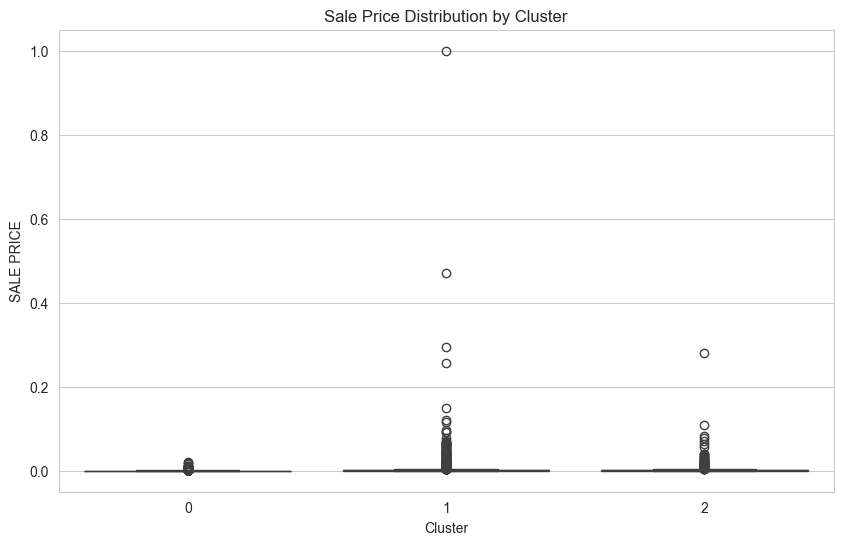

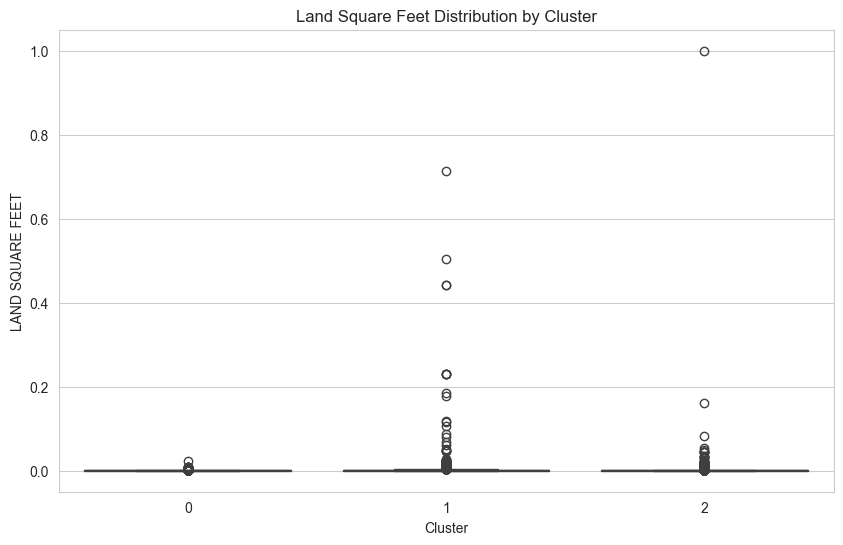

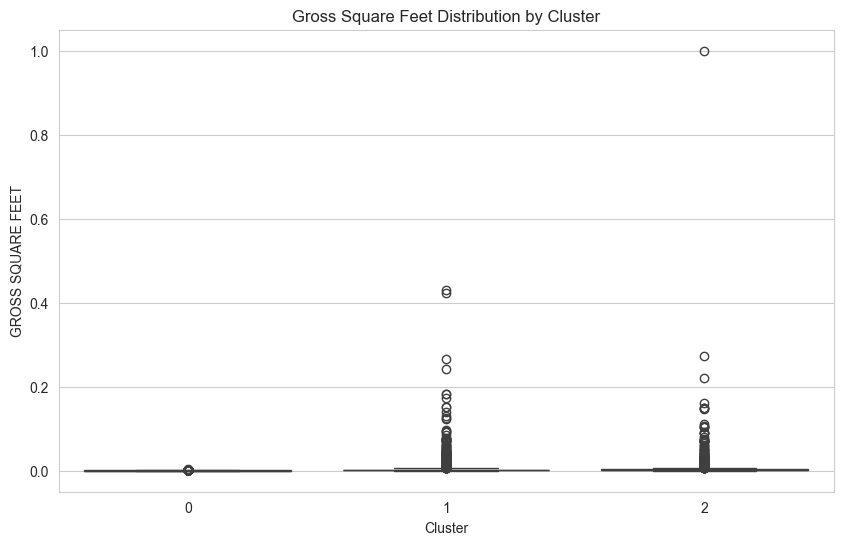

/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/791491401.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_df['Borough Name'] = final_features_df['BOROUGH'].map(borough_names)


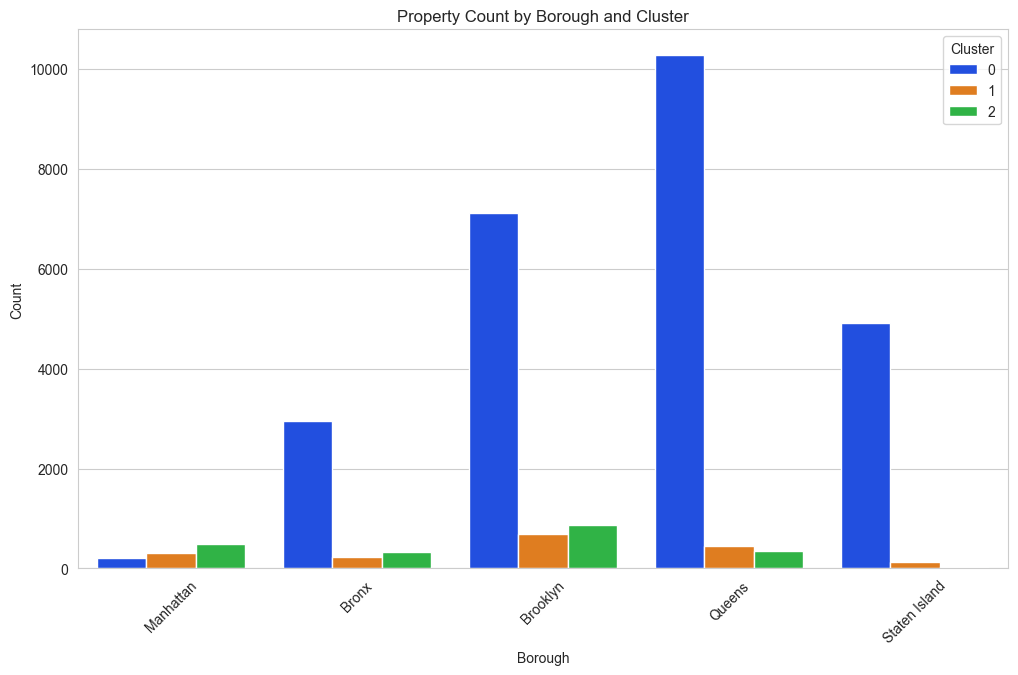

In [223]:
# Statistical Summary by Cluster
cluster_summary = final_features_df.groupby('Cluster').mean()
print(cluster_summary)


print('\n')


# Sale Price Distribution by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='SALE PRICE', data=final_features_df)
plt.title('Sale Price Distribution by Cluster')
plt.show()

# Land Square Feet Distribution by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='LAND SQUARE FEET', data=final_features_df)
plt.title('Land Square Feet Distribution by Cluster')
plt.show()

# Gross Square Feet Distribution by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='GROSS SQUARE FEET', data=final_features_df)
plt.title('Gross Square Feet Distribution by Cluster')
plt.show()


print('\n')


# Mapping for encoded boroughs to names
borough_names = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

# Apply the mapping to create a new column with borough names
final_features_df['Borough Name'] = final_features_df['BOROUGH'].map(borough_names)

# Now, update the geographical visualization code to use 'Borough Name'
plt.figure(figsize=(12, 7))
sns.countplot(x='Borough Name', hue='Cluster', data=final_features_df, palette='bright')
plt.title('Property Count by Borough and Cluster')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.xticks(rotation=45)  # Rotate the borough names for better readability
plt.show()


/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/3716578335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_df[numeric_features] = scaler.inverse_transform(final_features_df[numeric_features])
/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/3716578335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_df['Log Sale Price'] = np.log(final_features_df['SALE PRICE'])
/var/folders/z1/kzyz7bpj7vvbpsrp2xyd94740000gn/T/ipykernel_82355/3716578335.py

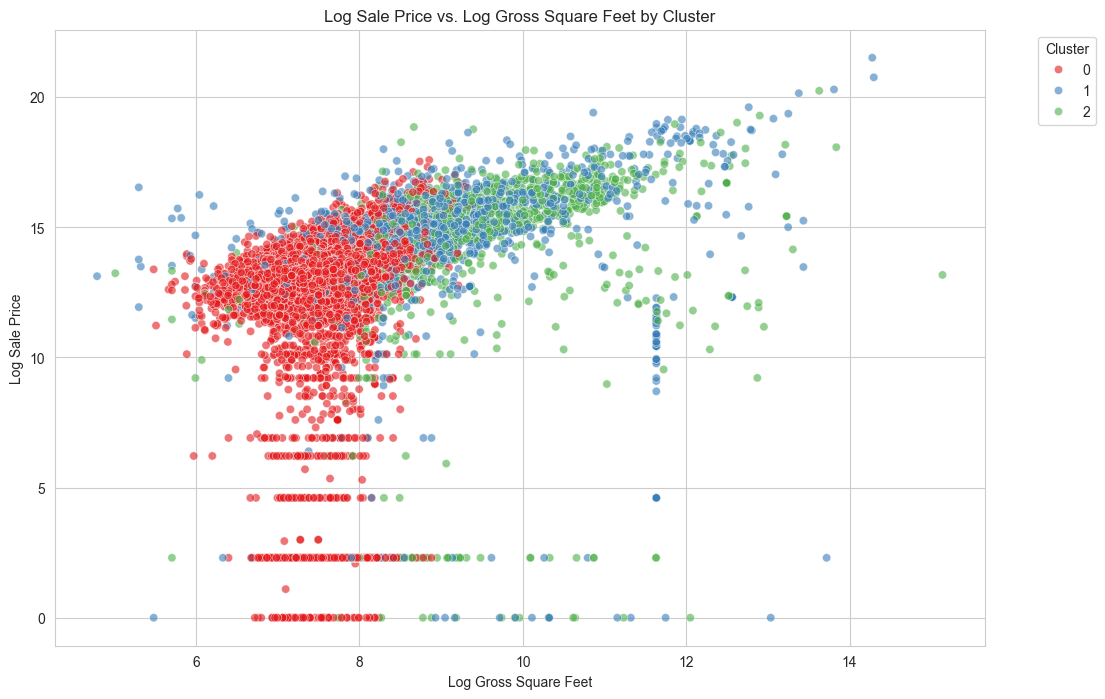

In [224]:
# Apply log transformation and avoid log(0) by ading a small constant (e.g., 1) if there are zero values in the data
final_features_df[numeric_features] = scaler.inverse_transform(final_features_df[numeric_features])

final_features_df['Log Sale Price'] = np.log(final_features_df['SALE PRICE'])
final_features_df['Log Gross Square Feet'] = np.log(final_features_df['GROSS SQUARE FEET'])

# Scatter Plot with Log Transformation
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Log Gross Square Feet', y='Log Sale Price', hue='Cluster', data=final_features_df, palette='Set1', alpha=0.6)
plt.title('Log Sale Price vs. Log Gross Square Feet by Cluster')
plt.xlabel('Log Gross Square Feet')
plt.ylabel('Log Sale Price')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()